# Measuring the water level of a Heeia Fishpond

Natebook showcases an example of Earth observation processing chain that determines water levels of any water body (dam, reservoir, lake, ...) from satellite imagery. The entire processing chain is performed using the `eo-learn` package. The user simply needs to provide a polygon with water body's nominal water extent.

In [134]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Imports

In [135]:
# For manipulating geo-spatial vector dataset (polygons of nominal water extent)
import geopandas as gpd

# import matplotlib
import matplotlib.pyplot as plt

# The golden standard: numpy and matplotlib
import numpy as np

# Loading polygon of nominal water extent
import shapely.wkt

# Image manipulations
# Our water detector is going to be based on a simple threshold
# of Normalised Difference Water Index (NDWI) grayscale image
from skimage.filters import threshold_otsu

# sentinelhub-py package
from sentinelhub import CRS, BBox, DataCollection

# eo-learn core building blocks
from eolearn.core import EOTask, EOWorkflow, FeatureType, OutputTask, linearly_connect_tasks

# filtering of scenes
from eolearn.features import NormalizedDifferenceIndexTask, SimpleFilterTask

# burning the vectorised polygon to raster
from eolearn.geometry import VectorToRasterTask
from eolearn.io import SentinelHubInputTask

## Water level extraction EOWorkflow

Our basic logic of the example workflow is:

1. Download all available Sentinel-2 sattelite imagery of Theewaterskloof Dam from beginning of 2016 and today
    * We want to calculate NDWI and also have a true color visualization of the area. We need the following bands: 
        * B02, B03, B04 for `TRUE_COLOR` for visualisations
        * B03, B08 for NDWI calculation 
        * CLM (provided by Sentinel Hub) for cloud masking
2. Clouds are very often obscuring the view of the ground. In order to correctly determine the water level of the dam all images with clouds need to be filtered out. We will use the cloud masks provided by Sentinel Hub to filter clouds without the need for time consuming processing locally.
3. Apply adaptive thresholding to `NDWI` grayscale images
4. Extract water level from a comparison of measured water extent with the nominal one

Each step in the above overview of the workflow is accomplished by adding an `EOTask` to the `EOWorkflow`

### Load the Polygon of nominal water extent and define a `BBox`

The `BBox` defines an area of interest and will be used to create an EOPatch.

In [136]:
wkt_polygon = """
POLYGON ((
    -157.8096535 21.4398339, 
    -157.8101041 21.4391348, 
    -157.8105977 21.4386355, 
    -157.8105333 21.4384158, 
    -157.8107479 21.4378965, 
    -157.8108551 21.4372973, 
    -157.8105547 21.4372174, 
    -157.8103616 21.4369777, 
    -157.8099754 21.4358992, 
    -157.8095248 21.4350603, 
    -157.8093316 21.4349205, 
    -157.8089454 21.4343413, 
    -157.8084948 21.4335423, 
    -157.8082158 21.4331828, 
    -157.8074434 21.4323838, 
    -157.8073361 21.4320043, 
    -157.8069928 21.431525, 
    -157.8067782 21.4315449, 
    -157.8063061 21.4317447, 
    -157.8055122 21.4333426, 
    -157.8051474 21.4342214, 
    -157.8050401 21.4347607, 
    -157.8057911 21.4371775, 
    -157.8064134 21.4379764, 
    -157.8068855 21.4385956, 
    -157.8074434 21.4391748, 
    -157.8079798 21.4396342, 
    -157.8084733 21.4399937, 
    -157.8087094 21.4397939, 
    -157.8089883 21.4397939, 
    -157.8093102 21.4399138, 
    -157.8096535 21.4398339
))
"""

with open("heeia_fishpond.wkt", "w") as file:
    file.write(wkt_polygon.strip())


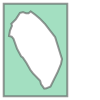

In [137]:
# The polygon of the dam is written in wkt format and WGS84 coordinate reference system
with open("heeia_fishpond.wkt", "r") as f:
    heeia_wkt = f.read()

heeia_nominal = shapely.wkt.loads(heeia_wkt)

# inflate the BBOX
inflate_bbox = 0.1
minx, miny, maxx, maxy = heeia_nominal.bounds

delx = maxx - minx
dely = maxy - miny
minx = minx - delx * inflate_bbox
maxx = maxx + delx * inflate_bbox
miny = miny - dely * inflate_bbox
maxy = maxy + dely * inflate_bbox

heeia_bbox = BBox([minx, miny, maxx, maxy], crs=CRS.WGS84)

heeia_bbox.geometry - heeia_nominal

### Step 1: Intialize (and implement workflow specific) EOTasks

#### Create an EOPatch and add all EO features (satellite imagery data)

In [139]:
download_task = SentinelHubInputTask(
    data_collection=DataCollection.SENTINEL2_L1C,
    bands_feature=(FeatureType.DATA, "BANDS"),
    resolution=20,
    maxcc=0.5,
    bands=["B02", "B03", "B04", "B08"],
    additional_data=[(FeatureType.MASK, "dataMask", "IS_DATA"), (FeatureType.MASK, "CLM")],
    cache_folder="cached_data",
)

calculate_ndwi = NormalizedDifferenceIndexTask((FeatureType.DATA, "BANDS"), (FeatureType.DATA, "NDWI"), (1, 3))

#### Burn in the nominal water extent

The `VectorToRaster` task expects the vectorised dataset in geopandas dataframe.

In [140]:
heeia_gdf = gpd.GeoDataFrame(crs=CRS.WGS84.pyproj_crs(), geometry=[heeia_nominal])

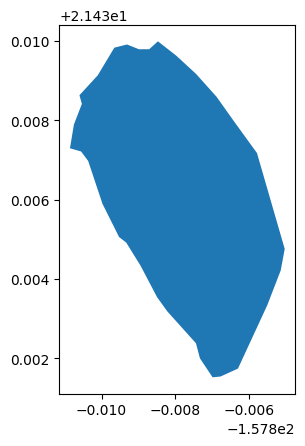

In [141]:
heeia_gdf.plot();

In [142]:
add_nominal_water = VectorToRasterTask(
    heeia_gdf,
    (FeatureType.MASK_TIMELESS, "NOMINAL_WATER"),
    values=1,
    raster_shape=(FeatureType.MASK, "IS_DATA"),
    raster_dtype=np.uint8,
)

#### The cloud mask is already provided by Sentinel Hub, we use it to calulcate the valid data mask. 

Define a `VALID_DATA` layer: pixel has to contain data and should be classified as clear sky by the cloud detector (`CLM` equals 0)

In [143]:
class AddValidDataMaskTask(EOTask):
    def execute(self, eopatch):
        is_data_mask = eopatch[FeatureType.MASK, "IS_DATA"].astype(bool)
        cloud_mask = ~eopatch[FeatureType.MASK, "CLM"].astype(bool)
        eopatch[FeatureType.MASK, "VALID_DATA"] = np.logical_and(is_data_mask, cloud_mask)
        return eopatch


add_valid_mask = AddValidDataMaskTask()

Calculate fraction of valid pixels per frame and store it as `SCALAR` feature

In [144]:
def calculate_coverage(array):
    return 1.0 - np.count_nonzero(array) / np.size(array)


class AddValidDataCoverageTask(EOTask):
    def execute(self, eopatch):
        valid_data = eopatch[FeatureType.MASK, "VALID_DATA"]
        time, height, width, channels = valid_data.shape

        coverage = np.apply_along_axis(calculate_coverage, 1, valid_data.reshape((time, height * width * channels)))

        eopatch[FeatureType.SCALAR, "COVERAGE"] = coverage[:, np.newaxis]
        return eopatch


add_coverage = AddValidDataCoverageTask()

Filter out too cloudy scenes. We filter out all observation which have cloud coverage of more than 5%. 


In [145]:
cloud_coverage_threshold = 0.05


class ValidDataCoveragePredicate:
    def __init__(self, threshold):
        self.threshold = threshold

    def __call__(self, array):
        return calculate_coverage(array) < self.threshold


remove_cloudy_scenes = SimpleFilterTask(
    (FeatureType.MASK, "VALID_DATA"), ValidDataCoveragePredicate(cloud_coverage_threshold)
)

#### Apply Water Detection



In [146]:
class WaterDetectionTask(EOTask):
    @staticmethod
    def detect_water(ndwi):
        """Very simple water detector based on Otsu thresholding method of NDWI."""
        otsu_thr = 1.0
        if len(np.unique(ndwi)) > 1:
            ndwi[np.isnan(ndwi)] = -1
            otsu_thr = threshold_otsu(ndwi)

        return ndwi > otsu_thr

    def execute(self, eopatch):
        water_masks = np.asarray([self.detect_water(ndwi[..., 0]) for ndwi in eopatch.data["NDWI"]])

        # we're only interested in the water within the dam borders
        water_masks = water_masks[..., np.newaxis] * eopatch.mask_timeless["NOMINAL_WATER"]

        water_levels = np.asarray(
            [np.count_nonzero(mask) / np.count_nonzero(eopatch.mask_timeless["NOMINAL_WATER"]) for mask in water_masks]
        )

        eopatch[FeatureType.MASK, "WATER_MASK"] = water_masks
        eopatch[FeatureType.SCALAR, "WATER_LEVEL"] = water_levels[..., np.newaxis]

        return eopatch


water_detection = WaterDetectionTask()

### Step 2: Define the EOWorkflow

In [147]:
# To access the final data we use the OutputTask (alternatively we could save the eopatch)
output_task = OutputTask("final_eopatch")


workflow_nodes = linearly_connect_tasks(
    download_task,
    calculate_ndwi,
    add_nominal_water,
    add_valid_mask,
    add_coverage,
    remove_cloudy_scenes,
    water_detection,
    output_task,
)
workflow = EOWorkflow(workflow_nodes)

### Step 3: Run the workflow

Process all Sentinel-2 acquisitions from beginning of 2016 and until beginning of June 2020.

In [148]:
time_interval = ["2019-01-01", "2024-01-01"]

In [149]:
# The download task requires additional arguments at execution. These are linked to the node the task is in.
download_node = workflow_nodes[0]

result = workflow.execute(
    {
        download_node: {"bbox": heeia_bbox, "time_interval": time_interval},
    }
)

result

/Users/connorflynn/opt/anaconda3/lib/python3.8/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/connorflynn/opt/anaconda3/lib/python3.8/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/connorflynn/opt/anaconda3/lib/python3.8/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/connorflynn/opt/anaconda3/lib/python3.8/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/connorflynn/opt/anaconda3/lib/python3.8/site-packages/sentinelhub/download/sentinelhub_client.py:

WorkflowResults(outputs={'final_eopatch': EOPatch(
  bbox=BBox(((-157.8114366, 21.43067813), (-157.8044586, 21.44084057)), crs=CRS('4326'))
  timestamps=[2019-01-06 21:09:32, ...]<length=120>
  scalar={
    COVERAGE: numpy.ndarray(shape=(120, 1), dtype=float64)
    WATER_LEVEL: numpy.ndarray(shape=(120, 1), dtype=float64)
  }
  mask_timeless={
    NOMINAL_WATER: numpy.ndarray(shape=(57, 36, 1), dtype=uint8)
  }
  mask={
    CLM: numpy.ndarray(shape=(120, 57, 36, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(120, 57, 36, 1), dtype=bool)
    VALID_DATA: numpy.ndarray(shape=(120, 57, 36, 1), dtype=bool)
    WATER_MASK: numpy.ndarray(shape=(120, 57, 36, 1), dtype=uint8)
  }
  data={
    BANDS: numpy.ndarray(shape=(120, 57, 36, 4), dtype=float32)
    NDWI: numpy.ndarray(shape=(120, 57, 36, 1), dtype=float32)
  }
)}, start_time=datetime.datetime(2024, 5, 28, 9, 56, 42, 427637), end_time=datetime.datetime(2024, 5, 28, 9, 58, 35, 53329), stats={'SentinelHubInputTask-6427a0941d2c11efad4a-4

Print content of eopatch at the end of the workflow execution

In [150]:
patch = result.outputs["final_eopatch"]
patch

EOPatch(
  bbox=BBox(((-157.8114366, 21.43067813), (-157.8044586, 21.44084057)), crs=CRS('4326'))
  timestamps=[2019-01-06 21:09:32, ...]<length=120>
  scalar={
    COVERAGE: numpy.ndarray(shape=(120, 1), dtype=float64)
    WATER_LEVEL: numpy.ndarray(shape=(120, 1), dtype=float64)
  }
  mask_timeless={
    NOMINAL_WATER: numpy.ndarray(shape=(57, 36, 1), dtype=uint8)
  }
  mask={
    CLM: numpy.ndarray(shape=(120, 57, 36, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(120, 57, 36, 1), dtype=bool)
    VALID_DATA: numpy.ndarray(shape=(120, 57, 36, 1), dtype=bool)
    WATER_MASK: numpy.ndarray(shape=(120, 57, 36, 1), dtype=uint8)
  }
  data={
    BANDS: numpy.ndarray(shape=(120, 57, 36, 4), dtype=float32)
    NDWI: numpy.ndarray(shape=(120, 57, 36, 1), dtype=float32)
  }
)

# Plot results

In [151]:
from skimage.filters import sobel
from skimage.morphology import closing, disk

TypeError: Invalid shape (3, 57, 36) for image data

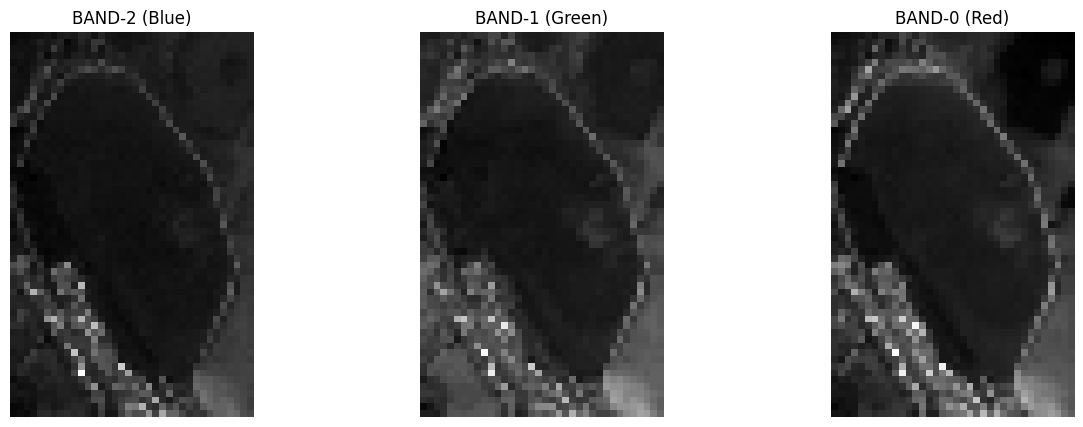

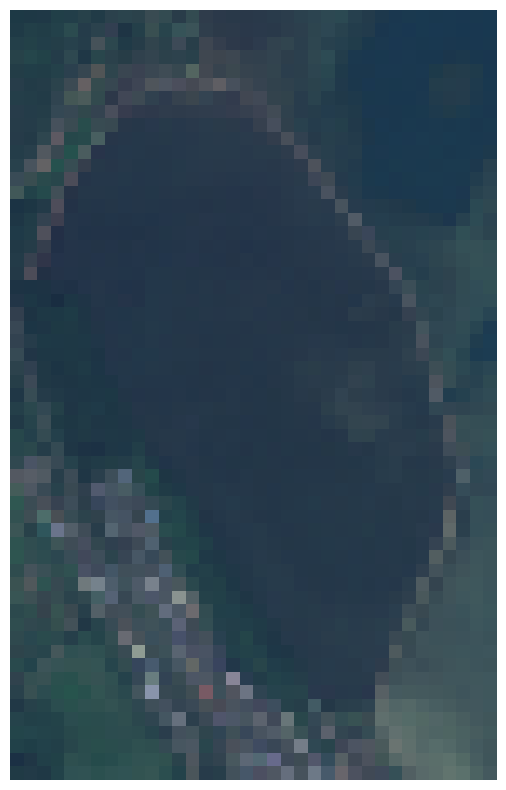

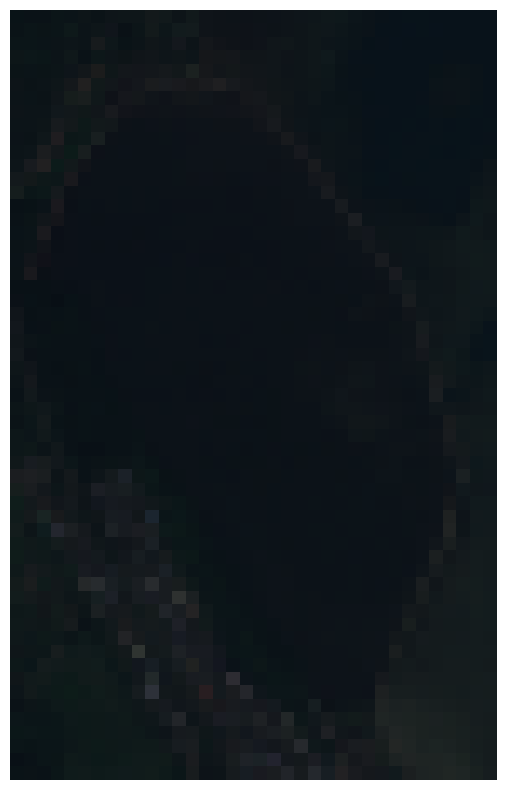

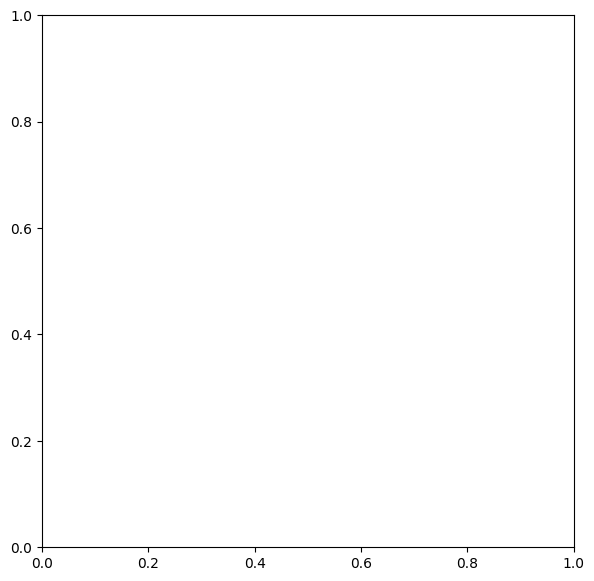

In [163]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import closing, disk
from skimage.filters import sobel
from skimage import exposure

# Function to plot raw bands
def plot_raw_bands(eopatch, idx):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    bands = ['BAND-2 (Blue)', 'BAND-1 (Green)', 'BAND-0 (Red)']
    for i, ax in enumerate(axes):
        band_data = eopatch.data["BANDS"][idx, ..., i]
        ax.imshow(band_data, cmap='gray')
        ax.set_title(bands[i])
        ax.axis("off")

# Function to plot RGB image with scaling
def plot_rgb_only_with_scaling(eopatch, idx, scaling_factor=2.5):
    ratio = np.abs(eopatch.bbox.max_x - eopatch.bbox.min_x) / np.abs(eopatch.bbox.max_y - eopatch.bbox.min_y)
    fig, ax = plt.subplots(figsize=(ratio * 10, 10))
    rgb_image = np.clip(scaling_factor * eopatch.data["BANDS"][..., [2, 1, 0]][idx], 0, 1)
    ax.imshow(rgb_image)
    ax.axis("off")

# Function to normalize and plot RGB image
def plot_rgb_normalized(eopatch, idx):
    ratio = np.abs(eopatch.bbox.max_x - eopatch.bbox.min_x) / np.abs(eopatch.bbox.max_y - eopatch.bbox.min_y)
    fig, ax = plt.subplots(figsize=(ratio * 10, 10))
    bands = eopatch.data["BANDS"][idx, ..., [2, 1, 0]]
    norm_bands = (bands - np.min(bands)) / (np.max(bands) - np.min(bands))
    ax.imshow(np.clip(norm_bands * 2.5, 0, 1))
    ax.axis("off")

# Function to print image resolution
def print_image_resolution(eopatch, idx):
    bands_shape = eopatch.data["BANDS"][idx].shape
    print(f"Resolution of image bands: {bands_shape}")

# Function to check for data anomalies
def check_data_anomalies(eopatch, idx):
    bands = eopatch.data["BANDS"][idx, ..., [2, 1, 0]]
    if np.isnan(bands).any():
        print("Data contains NaN values")
    if np.isinf(bands).any():
        print("Data contains infinite values")
    print(f"Band data range: min={bands.min()}, max={bands.max()}")

# Function to plot RGB image with histogram equalization
def plot_rgb_with_equalization(eopatch, idx):
    ratio = np.abs(eopatch.bbox.max_x - eopatch.bbox.min_x) / np.abs(eopatch.bbox.max_y - eopatch.bbox.min_y)
    fig, ax = plt.subplots(figsize=(ratio * 10, 10))
    bands = eopatch.data["BANDS"][idx, ..., [2, 1, 0]]
    norm_bands = (bands - np.min(bands)) / (np.max(bands) - np.min(bands))
    equalized_bands = exposure.equalize_adapthist(norm_bands)
    ax.imshow(np.clip(equalized_bands * 2.5, 0, 1))
    ax.axis("off")

# Function to plot masks
def plot_masks(eopatch, idx):
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    observed_mask = closing(eopatch.mask["WATER_MASK"][idx, ..., 0], disk(1))
    axes[0].imshow(observed_mask, cmap='Blues')
    axes[0].set_title('Observed Water Mask')
    axes[0].axis("off")
    nominal_mask = eopatch.mask_timeless["NOMINAL_WATER"][..., 0]
    axes[1].imshow(nominal_mask, cmap='Reds')
    axes[1].set_title('Nominal Water Mask')
    axes[1].axis("off")

# Function to plot RGB image with water masks
def plot_rgb_w_water(eopatch, idx, scaling_factor=2.5, alpha_nominal=0.5, alpha_observed=0.5):
    ratio = np.abs(eopatch.bbox.max_x - eopatch.bbox.min_x) / np.abs(eopatch.bbox.max_y - eopatch.bbox.min_y)
    fig, ax = plt.subplots(figsize=(ratio * 10, 10))
    rgb_image = np.clip(scaling_factor * eopatch.data["BANDS"][..., [2, 1, 0]][idx], 0, 1)
    ax.imshow(rgb_image)
    observed = closing(eopatch.mask["WATER_MASK"][idx, ..., 0], disk(1))
    nominal = sobel(eopatch.mask_timeless["NOMINAL_WATER"][..., 0])
    observed = sobel(observed)
    nominal = np.ma.masked_where(~nominal.astype(bool), nominal)
    observed = np.ma.masked_where(~observed.astype(bool), observed)
    ax.imshow(nominal, cmap=plt.cm.Reds, alpha=alpha_nominal)
    ax.imshow(observed, cmap=plt.cm.Blues, alpha=alpha_observed)
    ax.axis("off")

# Example usage with your patch data
plot_raw_bands(patch, 0)
plot_rgb_only_with_scaling(patch, 0, scaling_factor=3.0)
plot_rgb_only_with_scaling(patch, 0, scaling_factor=1.0)
plot_rgb_normalized(patch, 0)
print_image_resolution(patch, 0)
check_data_anomalies(patch, 0)
plot_rgb_with_equalization(patch, 0)
plot_masks(patch, 0)
plot_rgb_w_water(patch, 0, scaling_factor=1.5, alpha_nominal=0.3, alpha_observed=0.3)



In [164]:
def plot_rgb_w_water(patch, idx):
    ratio = np.abs(patch.bbox.max_x - patch.bbox.min_x) / np.abs(patch.bbox.max_y - patch.bbox.min_y)
    fig, ax = plt.subplots(figsize=(ratio * 10, 10))

    ax.imshow(np.clip(2.5 * patch.data["BANDS"][..., [2, 1, 0]][idx], 0, 1))

    observed = closing(patch.mask["WATER_MASK"][idx, ..., 0], disk(1))
    nominal = sobel(patch.mask_timeless["NOMINAL_WATER"][..., 0])
    observed = sobel(observed)
    nominal = np.ma.masked_where(~nominal.astype(bool), nominal)
    observed = np.ma.masked_where(~observed.astype(bool), observed)

    ax.imshow(nominal, cmap=plt.cm.Reds)
    ax.imshow(observed, cmap=plt.cm.Blues)
    ax.axis("off")




In [165]:
print(patch.data["BANDS"].shape)
print(patch.mask["WATER_MASK"].shape)
print(patch.mask_timeless["NOMINAL_WATER"].shape)



(120, 57, 36, 4)
(120, 57, 36, 1)
(57, 36, 1)


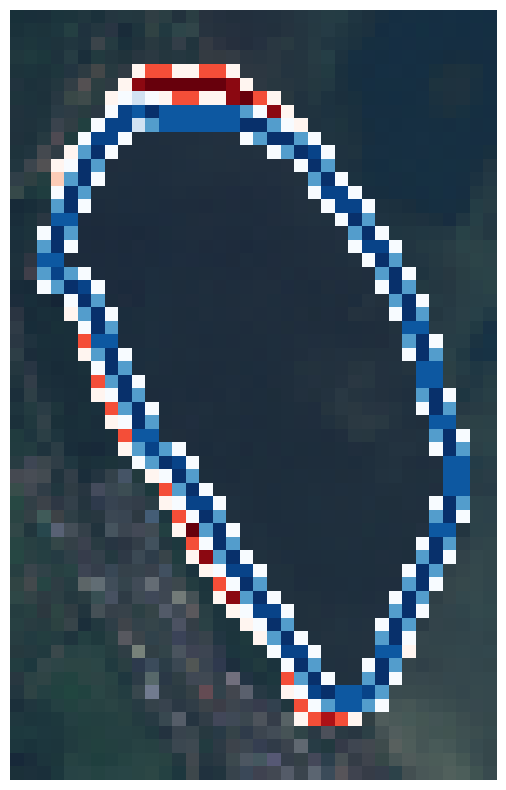

In [154]:
plot_rgb_w_water(patch, 0)

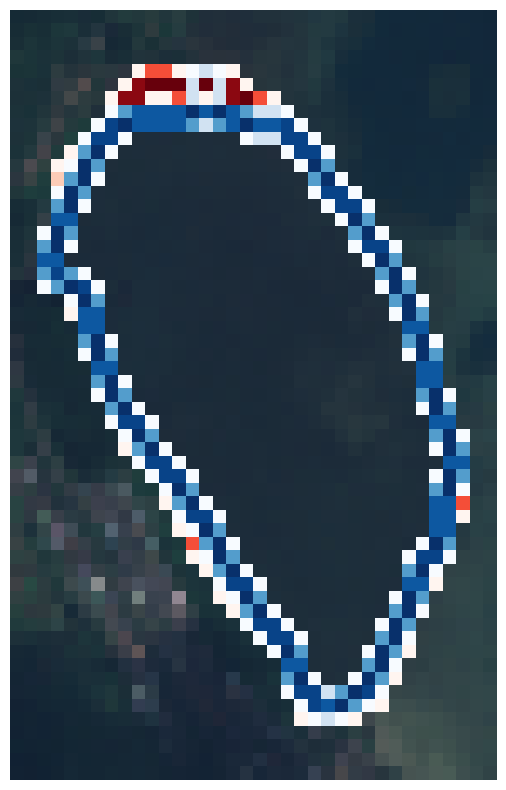

In [157]:
plot_rgb_w_water(patch, 2)

In [166]:
def plot_water_levels(eopatch, max_coverage=1.0):
    fig, ax = plt.subplots(figsize=(20, 7))

    dates = np.asarray(eopatch.timestamps)
    ax.plot(
        dates[eopatch.scalar["COVERAGE"][..., 0] < max_coverage],
        eopatch.scalar["WATER_LEVEL"][eopatch.scalar["COVERAGE"][..., 0] < max_coverage],
        "bo-",
        alpha=0.7,
    )
    ax.plot(
        dates[eopatch.scalar["COVERAGE"][..., 0] < max_coverage],
        eopatch.scalar["COVERAGE"][eopatch.scalar["COVERAGE"][..., 0] < max_coverage],
        "--",
        color="gray",
        alpha=0.7,
    )
    ax.set_ylim(0.0, 1.1)
    ax.set_xlabel("Date")
    ax.set_ylabel("Water level")
    ax.set_title("Heeia Fishpond Water Levels")
    ax.grid(axis="y")
    return ax

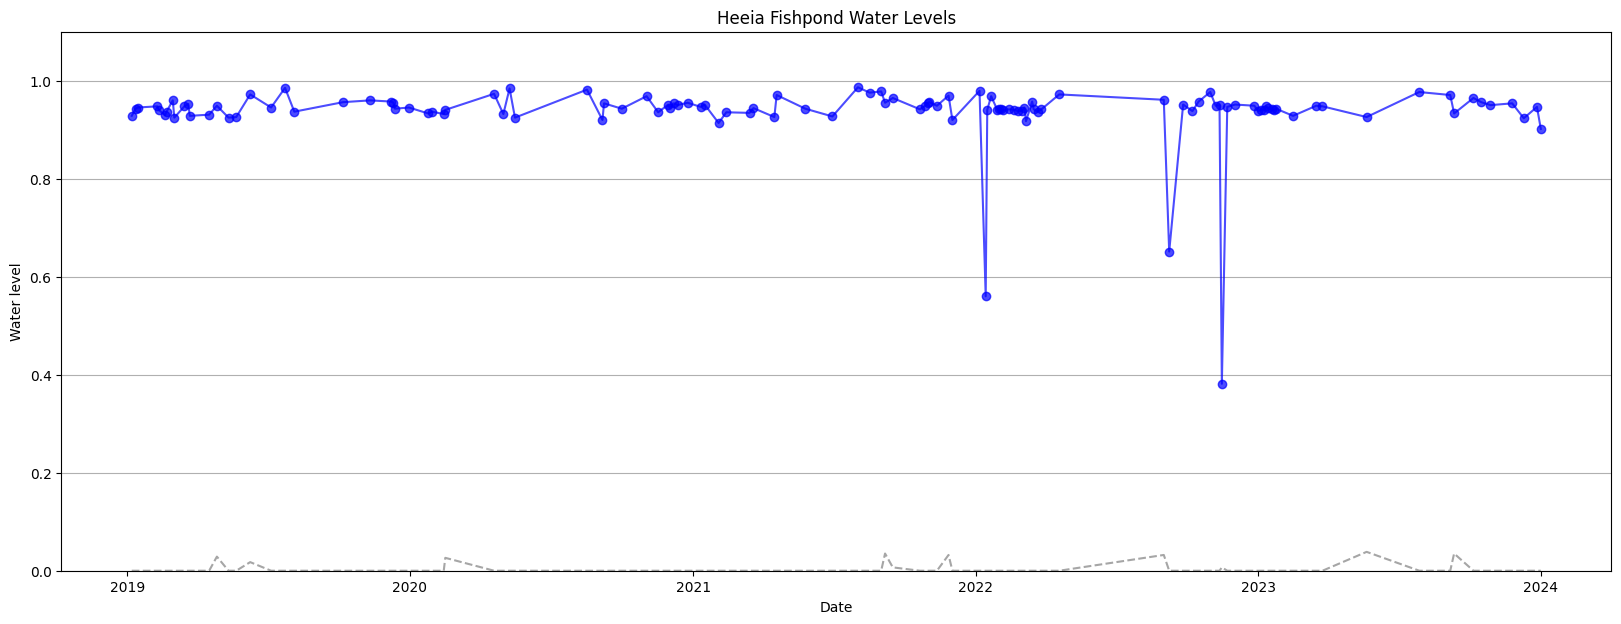

In [167]:
ax = plot_water_levels(patch, 1.0)